# Séance 3 - Compléments

Dans cette séance nous travaillerons avec le dataset d'image CIFAR10. Il correspond à des petites images en couleurs. Notre objectif est de construire un réseau de neurones convolutionnel capable d'identifier chacun des dix types.

Commençons par importer quelques librairies qui nous serons utile pour la suite:
* **Numpy** : Calcul matriciel
* **Pandas** : Travail avec des DataFrame
* **Matplotlib** : Graphiques, et on utilise également la sur-couche **seaborn**
* **Tensorflow** : librairie qui permet la définition de réseau de neurones, et une *interface* plus simple d'utilisation **Keras**

Nous allons également importer les données et initialiser la data augmentation.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras



cifar10 = keras.datasets.cifar10
(X_train, y_train), (X_valid, y_valid) = (cifar10.load_data())
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)

label_map = {0: "airplane", 1: "automobile", 2: "bird",
             3: "cat", 4: "deer", 5: "dog",
             6: "frog", 7: "horse", 8: "ship", 9: "truck  "}


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 32 * 32 * 3)).reshape(-1, 32, 32, 3)
X_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 32 * 32 * 3)).reshape(-1, 32, 32, 3)



from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

170498071/170498071 [==============================] - 4s 0us/step


## Sujet B - Échéanciers pour le learning rate

On se propose ici d'étudier l'échéancier cosinus decay et plus spécifiquement l'impact sur les performances de la longueur du decay.

Les decay auront pour longueur 5, 10 et 15 époques et ferons passer le learning rate de 0.1 à 1e-4. On veut mesurer les impacts à court et moyen/long terme donc on continuera l'entraînement jusqu'à l'époque 30.

Visualisons les différentes valeurs que prendont les learning rates:

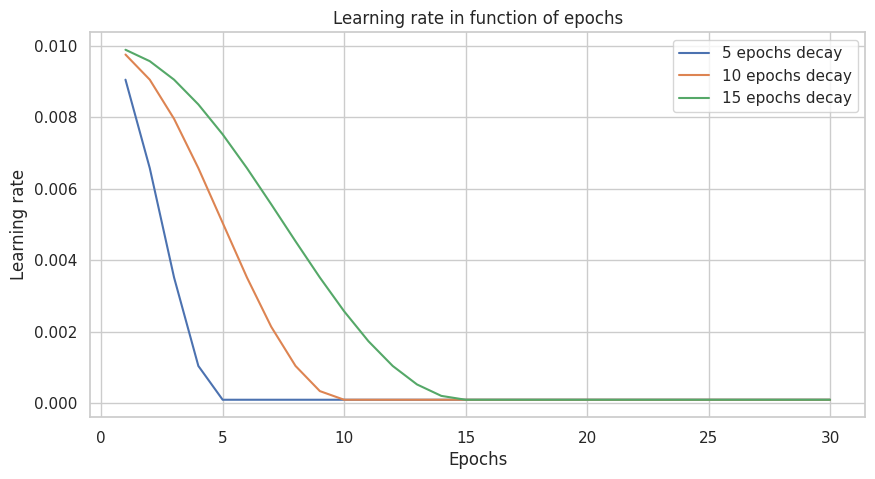

In [2]:
epochs = range(1, 31)
initial_learning_rate = 1e-2

def cosinus_decay(epoch, initial_learning_rate, decay_epochs, alpha=0.01):
  epoch = min(epoch, decay_epochs)
  cosine_decay = 0.5 * (1 + np.cos(np.pi * epoch / decay_epochs))
  decay = (1 - alpha) * cosine_decay + alpha
  return initial_learning_rate * decay


plt.figure(figsize=(10, 5))
for decay in [5, 10, 15]:
  plt.plot(epochs, [cosinus_decay(epoch, initial_learning_rate=initial_learning_rate, decay_epochs=decay) for epoch in epochs], label="%d epochs decay" % decay)

plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.title("Learning rate in function of epochs")
plt.legend()
plt.show()


Nous le ferons en exploitant un réseau de neurones convolutionnel. Commençons par définir le réseau de neurones que l'on va exploiter.

In [3]:
def generate_model():
  model = keras.models.Sequential([
      keras.layers.Conv2D(filters=32, kernel_size=3, padding="valid", activation="relu", kernel_initializer="he_normal", input_shape=[32, 32, 3]),
      keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
      keras.layers.MaxPool2D(pool_size=2),

      keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
      keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
      keras.layers.MaxPool2D(pool_size=2),

      keras.layers.Flatten(),
      keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
      keras.layers.Dropout(rate=0.25),
      keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
      keras.layers.Dense(10, activation="softmax", kernel_initializer="he_normal")
  ])
  return model


model = generate_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                   

En s'appuyant sur les corrections de TP précédentes, nous allons entraîner plusieurs fois la même architecture pour des longueurs de decay différentes, puis afficherons les performances.

In [4]:
def train_model(model, decay_step, verbose=0):
  decay_steps = (X_train.shape[0] // batch_size) * decay_step
  scheduler = keras.optimizers.schedules.CosineDecay(initial_learning_rate=initial_learning_rate, decay_steps=decay_steps, alpha=alpha)
  model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=scheduler), metrics=["accuracy"])
  history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch = X_train.shape[0] // batch_size, epochs=n_epochs, validation_data=(X_valid, y_valid), verbose=verbose)
  return pd.DataFrame(history.history)

batch_size = 32
n_epochs = 30
comparisons_number = 3
results = []

initial_learning_rate = 1e-2
alpha = 0.01

for index in range(comparisons_number):
  print("Comparison %d :" % (index+1), end=" ")
  for decay_step, key in zip([5, 10, 15], ["5 epochs decay", "10 epochs decay", "15 epochs decay"]):
    print("%s..." % key, end= " ")
    model = generate_model()
    history = train_model(model, decay_step)
    result = {"type": key, "history": history}
    results.append(result)
  print()

Comparison 1 : 5 epochs decay... 10 epochs decay... 15 epochs decay... 
Comparison 2 : 5 epochs decay... 10 epochs decay... 15 epochs decay... 
Comparison 3 : 5 epochs decay... 10 epochs decay... 15 epochs decay... 


On s'attend à ce que les decays les plus court apprennent le plus lentement, mais overfit moins que les decays les plus long. Vérifions en visualisant les courbes d'apprentissages:

In [5]:
def plot_comparison(results, title):

    def agregate_result(key, metric_name):
        training = np.zeros((comparisons_number, n_epochs))
        validation = np.zeros((comparisons_number, n_epochs))
        index = 0
        for result in results:
            if result["type"] == key:
              historic = result["history"]
              training[index] = historic[metric_name]
              validation[index] = historic["val_%s" % metric_name]
              index += 1
        return training, validation




    n_epochs = results[0]["history"].shape[0]
    epochs = range(1, n_epochs+1)
    figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))
    keys = list(set([result["type"] for result in results]))


    for metric_name, axis in zip(["loss", "accuracy"], [axis_1, axis_2]):

        for index, key in enumerate(keys):
            color = sns.color_palette()[index]
            training, validation = agregate_result(key, metric_name)
            axis.plot(epochs, training.mean(axis=0), lw=2, label=key, color=color)
            axis.fill_between(epochs, training.mean(axis=0)-3*training.std(axis=0), training.mean(axis=0)+3*training.std(axis=0), color=color, alpha=0.1)
            axis.plot(epochs, validation.mean(axis=0), ls="--", color=color)
            axis.fill_between(epochs, validation.mean(axis=0)-3*validation.std(axis=0), validation.mean(axis=0)+3*validation.std(axis=0), color=color, alpha=0.1)

        if metric_name == "accuracy": axis.set_ylim(0, 1)
        axis.set_ylabel(metric_name.capitalize())
        axis.set_xlabel("Epochs")
        axis.set_title("%s through training" % metric_name.capitalize())
        axis.legend()


    plt.suptitle(title)
    plt.show()

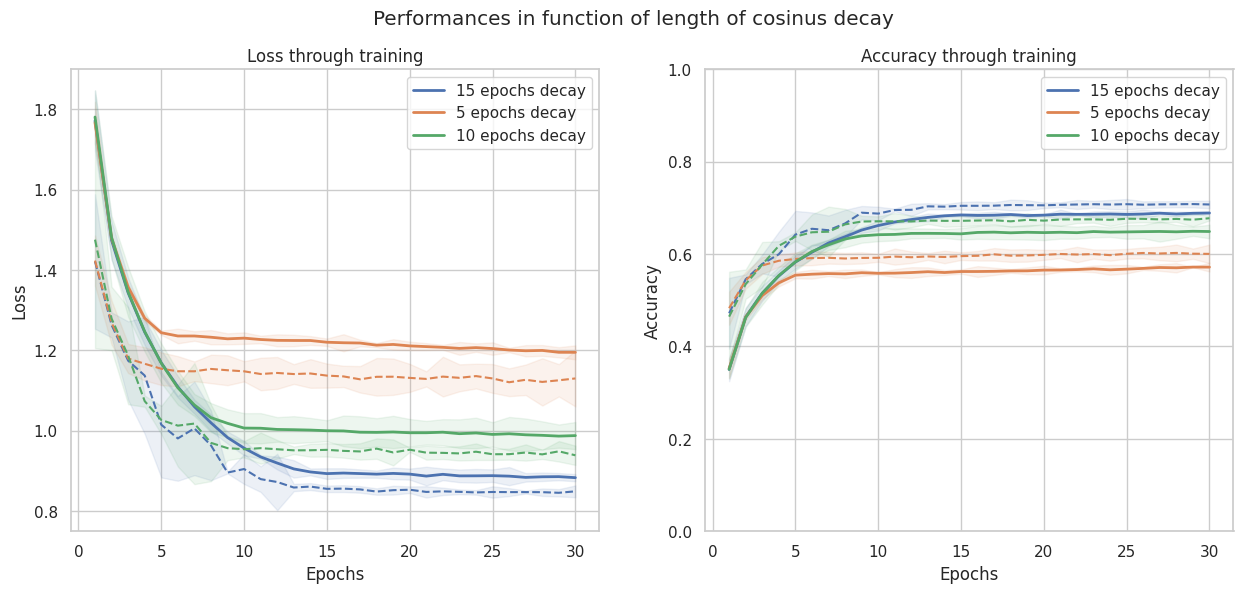

In [6]:
plot_comparison(results, "Performances in function of length of cosinus decay")

Les *decay* les plus courts apprennent effectivement le moins. Cependant, nous voyons ici que le réglage du learning rate n'est pas assez bon parce que nous sommes dans un régime d'underfitting !
On note très nettement le changement de pente dans la courbe d'apprentissage pour chacune des trois courbes. Il est intéressant de garder en tête ce comportement pour exploiter cet outil quand nous aurons un overfitting trop fort.

Pour avoir de meilleurs résultats, il semblerait qu'on doivent:
* Entraîner le réseau plus longtemps
* Laisser le decay plus longtemps

Des valeurs à tester pourraient être un entraînement sur 150 époques avec un decay à mi-parcours.